In [3]:
import pandas as pd

# Read the train.csv file
train_df = pd.read_csv('train.csv')

# Display first 5 rows
train_df.head()

,일자,기온,강수량(mm),풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5
0,2020-01-01-00,-6.5,0.0,0.0,0.0,38,1.4,1022.6,NaN,NaN,-2.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01-01,-5.9,NaN,1.7,50.0,40,1.6,1021.8,NaN,NaN,-2.4,0.002,0.036,0.6,0.003,30,16
2,2020-01-01-02,-5.7,NaN,0.1,0.0,42,1.7,1021.6,NaN,NaN,-2.4,0.001,0.036,0.6,0.003,34,18
3,2020-01-01-03,-5.6,0.0,0.0,0.0,46,1.8,1021.5,NaN,NaN,-2.7,0.002,0.038,0.8,0.003,35,22
4,2020-01-01-04,-5.4,NaN,0.0,0.0,50,2.0,1021.6,NaN,NaN,-2.5,0.001,0.034,0.6,0.003,34,19


In [4]:
# Count missing values for each column
missing_values = train_df.isnull().sum()

# Display the count of missing values
print("Missing values in each column:")
print(missing_values)

# Calculate percentage of missing values
total_rows = len(train_df)
missing_percentage = (missing_values / total_rows) * 100

# Display percentage of missing values
print("\nPercentage of missing values in each column:")
print(missing_percentage.round(2))

Missing values in each column:
일자               0
기온               1
강수량(mm)      31028
풍속(m/s)         39
풍향(16방위)        39
습도(%)            0
증기압(hPa)         2
현지기압(hPa)       13
일조(hr)       15899
일사(MJ/m2)    15899
지면온도(°C)        15
오 존            423
이산화질소         1603
일산화탄소          579
아황산가스          460
PM10           564
PM2.5          506
dtype: int64

Percentage of missing values in each column:
일자            0.00
기온            0.00
강수량(mm)      88.49
풍속(m/s)       0.11
풍향(16방위)      0.11
습도(%)         0.00
증기압(hPa)      0.01
현지기압(hPa)     0.04
일조(hr)       45.34
일사(MJ/m2)    45.34
지면온도(°C)      0.04
오 존           1.21
이산화질소         4.57
일산화탄소         1.65
아황산가스         1.31
PM10          1.61
PM2.5         1.44
dtype: float64


In [5]:
# Drop the 강수량(mm) column
train_df = train_df.drop('강수량(mm)', axis=1)

# Convert '일자' to datetime for better handling of time series data
train_df['일자'] = pd.to_datetime(train_df['일자'])

# Set '일자' as the index to make interpolation more accurate for time series data
train_df_indexed = train_df.set_index('일자')

# Interpolate missing values in '일조(hr)' and '일사(MJ/m2)'
train_df_indexed['일조(hr)'] = train_df_indexed['일조(hr)'].interpolate(method='time')
train_df_indexed['일사(MJ/m2)'] = train_df_indexed['일사(MJ/m2)'].interpolate(method='time')

# Reset index to get back the '일자' column
train_df = train_df_indexed.reset_index()

# Check the missing values after imputation
missing_after = train_df.isnull().sum()
print("Missing values after processing:")
print(missing_after)

# Display the first few rows to verify changes
train_df.head()

Missing values after processing:
일자              0
기온              1
풍속(m/s)        39
풍향(16방위)       39
습도(%)           0
증기압(hPa)        2
현지기압(hPa)      13
일조(hr)          8
일사(MJ/m2)       8
지면온도(°C)       15
오 존           423
이산화질소        1603
일산화탄소         579
아황산가스         460
PM10          564
PM2.5         506
dtype: int64


,일자,기온,풍속(m/s),풍향(16방위),습도(%),증기압(hPa),현지기압(hPa),일조(hr),일사(MJ/m2),지면온도(°C),오 존,이산화질소,일산화탄소,아황산가스,PM10,PM2.5
0,2020-01-01 00:00:00,-6.5,0.0,0.0,38,1.4,1022.6,NaN,NaN,-2.8,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01 01:00:00,-5.9,1.7,50.0,40,1.6,1021.8,NaN,NaN,-2.4,0.002,0.036,0.6,0.003,30,16
2,2020-01-01 02:00:00,-5.7,0.1,0.0,42,1.7,1021.6,NaN,NaN,-2.4,0.001,0.036,0.6,0.003,34,18
3,2020-01-01 03:00:00,-5.6,0.0,0.0,46,1.8,1021.5,NaN,NaN,-2.7,0.002,0.038,0.8,0.003,35,22
4,2020-01-01 04:00:00,-5.4,0.0,0.0,50,2.0,1021.6,NaN,NaN,-2.5,0.001,0.034,0.6,0.003,34,19


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         35064 non-null  datetime64[ns]
 1   기온         35063 non-null  float64       
 2   풍속(m/s)    35025 non-null  float64       
 3   풍향(16방위)   35025 non-null  float64       
 4   습도(%)      35064 non-null  int64         
 5   증기압(hPa)   35062 non-null  float64       
 6   현지기압(hPa)  35051 non-null  float64       
 7   일조(hr)     35056 non-null  float64       
 8   일사(MJ/m2)  35056 non-null  float64       
 9   지면온도(°C)   35049 non-null  float64       
 10  오 존        34641 non-null  object        
 11  이산화질소      33461 non-null  object        
 12  일산화탄소      34485 non-null  object        
 13  아황산가스      34604 non-null  object        
 14  PM10       34500 non-null  object        
 15  PM2.5      34558 non-null  object        
dtypes: datetime64[ns](1), float64(8), int64(

In [7]:
# 수치형 데이터로 변환
# PM2.5 외에도 PM10과 다른 대기 오염 데이터도 숫자형으로 변환
for col in ['PM10', '오 존', '이산화질소', '일산화탄소', '아황산가스']:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# 결측치 채우기
for column in train_df.columns:
    if train_df[column].dtype != 'datetime64[ns]':
        if pd.api.types.is_numeric_dtype(train_df[column]):
            # 수치형 열에는 평균 사용
            train_df[column] = train_df[column].fillna(train_df[column].mean())
        else:
            # 비수치형 열에는 최빈값 사용
            if not train_df[column].empty and len(train_df[column].mode()) > 0:
                train_df[column] = train_df[column].fillna(train_df[column].mode()[0])

Epoch 1/50


c:\Users\shinhs\miniconda3\envs\pythhhon\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


701/701 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0090 - val_loss: 0.0059
Epoch 2/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 4/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 5/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 7/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 8/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 11/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 12/50
701/701 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.

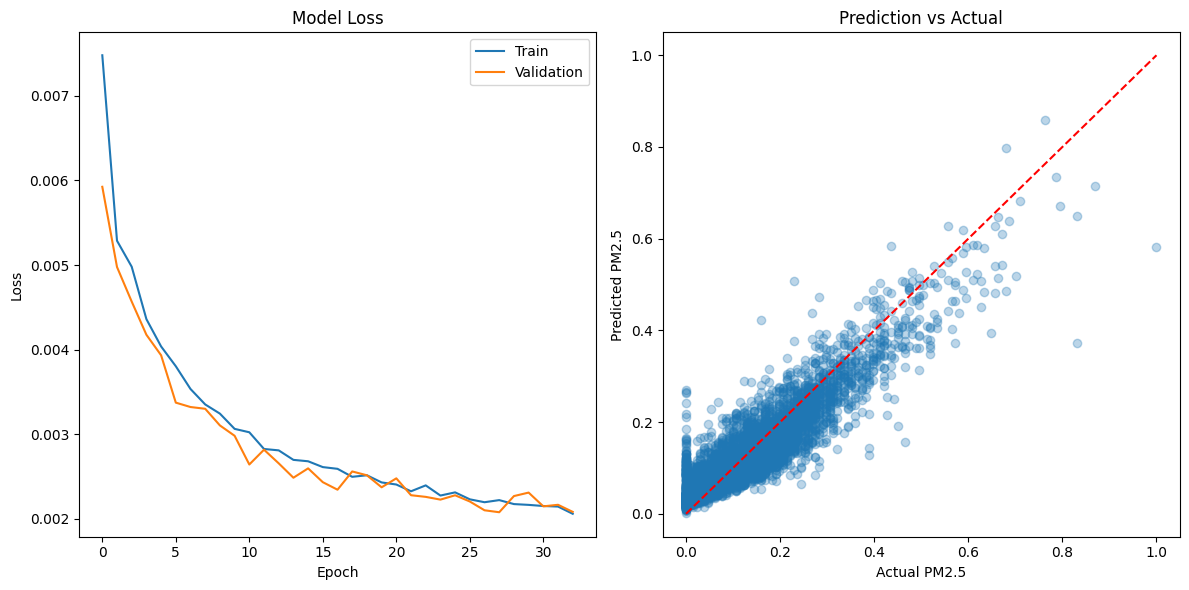

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

# Convert PM2.5 to numeric
train_df['PM2.5'] = pd.to_numeric(train_df['PM2.5'], errors='coerce')

# Fill remaining NaN values
for column in train_df.columns:
    if train_df[column].dtype != 'datetime64[ns]':
        train_df[column] = train_df[column].fillna(train_df[column].mean())

# Select features for prediction
features = ['기온', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '현지기압(hPa)', 
           '일조(hr)', '일사(MJ/m2)', '지면온도(°C)', 'PM10']
target = 'PM2.5'

# Prepare data for LSTM (create sequences)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

# Select data and normalize
data = train_df[features + [target]].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
seq_length = 24  # 24 hours (assuming hourly data)
X, y = create_sequences(data_scaled, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")

# Make predictions
y_pred = model.predict(X_test)

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot predictions vs actual
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Prediction vs Actual')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.tight_layout()
plt.show()

Training Random Forest model...
Training completed in 1.32 seconds

Model Evaluation:
Random Forest - MSE: 0.001838, R²: 0.835002
LSTM - MSE: 0.001969, R²: 0.815979


C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 50517 (\N{HANGUL SYLLABLE AB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\shinhs\AppData\Local\Temp\ipykernel_8332\4229969383.py:83: UserWarning: Glyph 47732 (\N{HANGUL SYLLABLE MYEON}) missing 

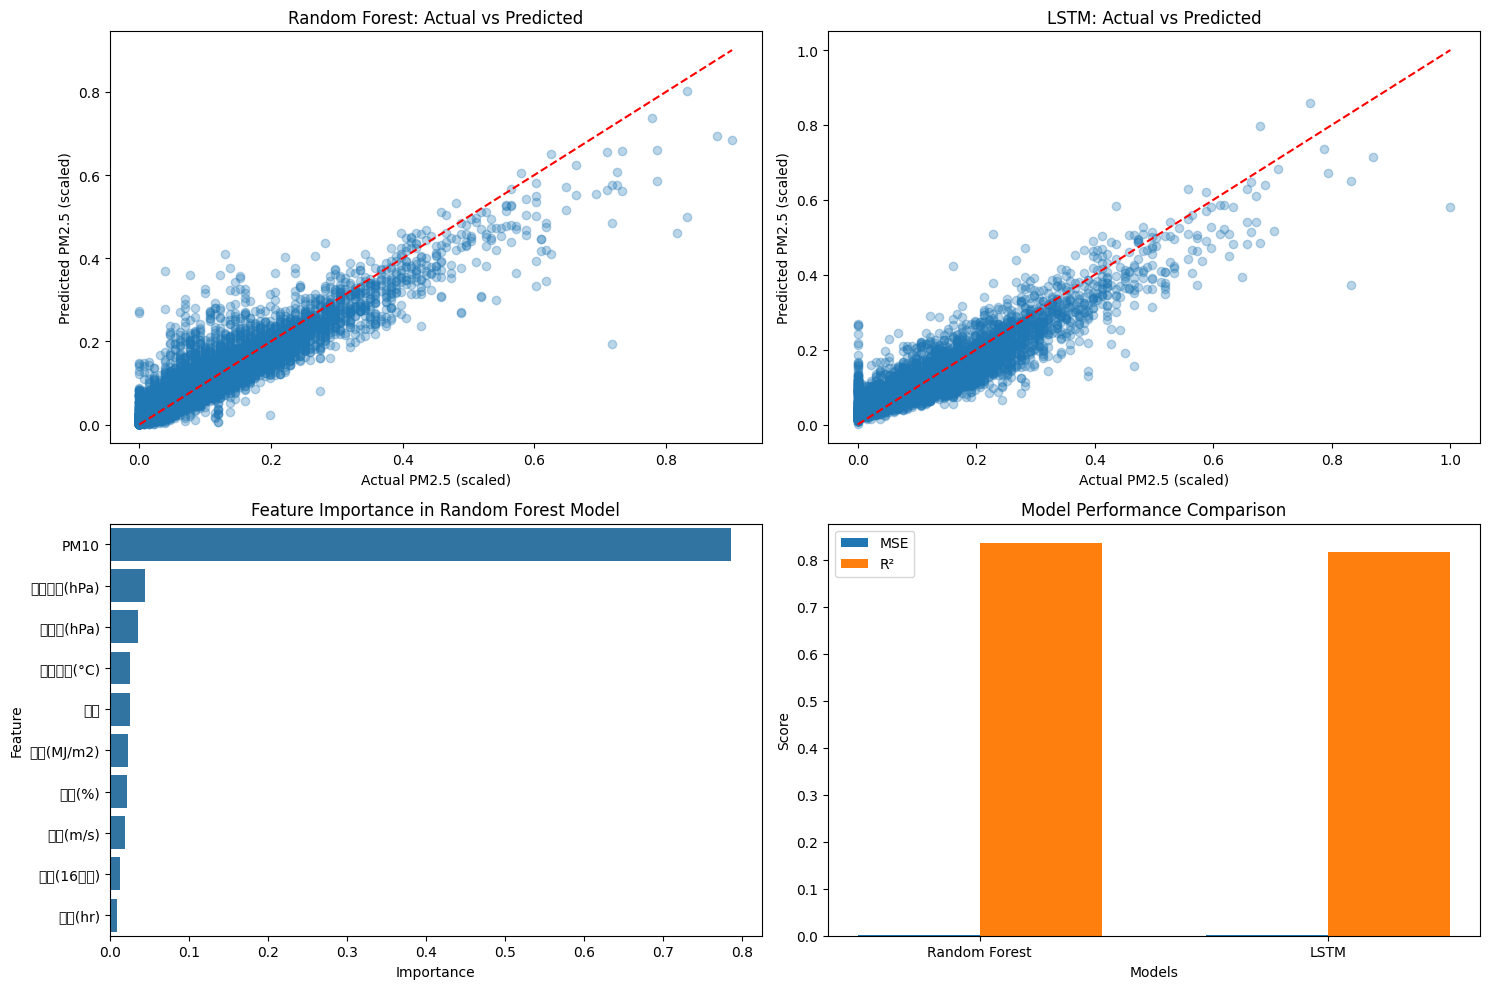

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import time
import seaborn as sns

# Import necessary libraries for Random Forest

# Prepare data for Random Forest (doesn't require sequences like LSTM)
# We need to extract the original features before scaling and sequence creation
X_data = train_df[features].values
y_data = train_df[target].values

# Use the same train-test split as the LSTM model
# But first convert data to correct format, since we don't need sequences
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_data_scaled = scaler_X.fit_transform(X_data)
y_data_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).ravel()

# Use train_test_split with the same random_state for consistency
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_data_scaled, y_data_scaled, test_size=0.2, random_state=42
)

# Train Random Forest model
print("Training Random Forest model...")
start_time = time.time()
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=15,
    random_state=42, 
    n_jobs=-1  # Use all available cores
)
rf_model.fit(X_train_rf, y_train_rf)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate the model
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

# Calculate LSTM metrics for comparison
mse_lstm = mean_squared_error(y_test, y_pred.ravel())
r2_lstm = r2_score(y_test, y_pred.ravel())

# Print results
print("\nModel Evaluation:")
print(f"Random Forest - MSE: {mse_rf:.6f}, R²: {r2_rf:.6f}")
print(f"LSTM - MSE: {mse_lstm:.6f}, R²: {r2_lstm:.6f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot results
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted for Random Forest
plt.subplot(2, 2, 1)
plt.scatter(y_test_rf, y_pred_rf, alpha=0.3)
plt.plot([min(y_test_rf), max(y_test_rf)], [min(y_test_rf), max(y_test_rf)], 'r--')
plt.title('Random Forest: Actual vs Predicted')
plt.xlabel('Actual PM2.5 (scaled)')
plt.ylabel('Predicted PM2.5 (scaled)')

# Plot 2: Actual vs Predicted for LSTM (similar to existing plot)
plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred.ravel(), alpha=0.3)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('LSTM: Actual vs Predicted')
plt.xlabel('Actual PM2.5 (scaled)')
plt.ylabel('Predicted PM2.5 (scaled)')

# Plot 3: Feature Importance
plt.subplot(2, 2, 3)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()

# Plot 4: Model Comparison
plt.subplot(2, 2, 4)
model_names = ['Random Forest', 'LSTM']
mse_values = [mse_rf, mse_lstm]
r2_values = [r2_rf, r2_lstm]

bar_width = 0.35
x = np.arange(len(model_names))

plt.bar(x - bar_width/2, mse_values, bar_width, label='MSE')
plt.bar(x + bar_width/2, r2_values, bar_width, label='R²')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
! pip install seaborn